In [1]:

import os
import re
import argparse
from email import policy
from email.parser import BytesParser

import nltk
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Ensure NLTK stopwords are downloaded
nltk.download('stopwords', quiet=True)
STOPWORDS = set(stopwords.words('english'))

import re
from nltk.stem import PorterStemmer

STOPWORDS = set(stopwords.words('english'))
stemmer = PorterStemmer()

def clean_text(text: str) -> str:
    text = text.lower()
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # strip URLs
    text = re.sub(r'[^a-z0-9\s]', ' ', text)           # strip punctuation
    text = re.sub(r'\s+', ' ', text).strip()           # collapse whitespace

    tokens = [
        stemmer.stem(word)
        for word in text.split()
        if word not in STOPWORDS
    ]
    return ' '.join(tokens)
print("done")

done


In [2]:
def load_emails(maildir: str):
    texts, labels = [], []
    cnt=0
    for user in os.listdir(maildir):
        user_dir = os.path.join(maildir, user)
        if not os.path.isdir(user_dir):
            continue

        # only look at the “sent_items” folder
        folder_dir = os.path.join(user_dir, "sent_items")
        print(cnt)
        cnt+=1
        if not os.path.isdir(folder_dir):
            continue

        for fname in os.listdir(folder_dir):
            path = os.path.join(folder_dir, fname)
            try:
                with open(path, 'rb') as f:
                    msg = BytesParser(policy=policy.default).parse(f) #read binary
                body = msg.get_body(preferencelist=('plain',))
                if body is None:
                    continue
                raw = body.get_content()
                text = clean_text(raw)
                if not text:
                    continue
                tokens = [w for w in text.split() if w not in STOPWORDS]  #cleanning. Added lemmentatizn or stemming?
                texts.append(' '.join(tokens))
                labels.append(user)
            except Exception:
                continue

    return texts, labels
print("done")


done


In [ ]:
DATA_DIR = "/WAVE/projects/CSEN-140-Sp25/HHJ140Proj/Sent_Items_only"     # path to Enron stuf
TEST_SIZE = 0.3
RANDOM_STATE = 36

print("Loading and cleaning emails…")
texts, labels = load_emails(DATA_DIR)
print(f"→ {len(texts)} messages from {len(set(labels))} authors")
print(len(texts))

Loading and cleaning emails…
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93


In [4]:
print("Vectorizing with TF–IDF…")
vect = TfidfVectorizer(max_features=20_000)
X = vect.fit_transform(texts)
y = labels

Vectorizing with TF–IDF…


In [5]:
from collections import Counter

counts = Counter(labels)

keep = {lbl for lbl, cnt in counts.items() if cnt >= 2}

texts_filt = [t for t, l in zip(texts, labels) if l in keep]
labels_filt = [l for l in labels if l in keep]

X = vect.transform(texts_filt)   
y = labels_filt

X_train, X_test, y_train, y_test = train_test_split( #split and train
    X, y,
    test_size=TEST_SIZE,
    stratify=y,
    random_state=RANDOM_STATE
)
print(f"→ Training on {X_train.shape[0]} docs; testing on {X_test.shape[0]}")

→ Training on 26364 docs; testing on 11299


In [9]:
import numpy as np
from collections import Counter

print("Data Statistics:")

# Label distribution
train_label_counts = Counter(y_train)
test_label_counts = Counter(y_test)

print(f"\nTraining Set Size: {X_train.shape[0]}")
print(f"Test Set Size: {X_test.shape[0]}")
print(f"Number of Features (TF–IDF): {X_train.shape[1]}")
print(f"Number of Unique Authors (Labels): {len(set(y_train))}")

print("\nTop 10 Authors in Training Set:")
for author, count in train_label_counts.most_common(10):
    print(f"{author}: {count} emails")

# Sparsity
nonzero_elements = X_train.count_nonzero()
total_elements = X_train.shape[0] * X_train.shape[1]
sparsity = 1.0 - (nonzero_elements / total_elements)
print(f"\nTF–IDF Matrix Sparsity: {sparsity:.4f}")


Data Statistics:

Training Set Size: 26364
Test Set Size: 11299
Number of Features (TF–IDF): 20000
Number of Unique Authors (Labels): 135

Top 10 Authors in Training Set:
kaminski-v: 1161 emails
dasovich-j: 1004 emails
steffes-j: 965 emails
germany-c: 935 emails
kitchen-l: 790 emails
watson-k: 677 emails
presto-k: 669 emails
blair-l: 650 emails
heard-m: 547 emails
lenhart-m: 536 emails

TF–IDF Matrix Sparsity: 0.9961


In [56]:
#These are the models JoJo is testing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
models = {
}

#modelsButPair =[()]
for i in range(1,50):
    kNumber= "k nearest neighbors k=" + str(i)
    models[kNumber]=KNeighborsClassifier(n_neighbors=i)
    #modelsButPair[i-1]=zip(i,KNeighborsClassifier(n_neighbors=i))
for name, model in models.items():
    print(f"\n{name}")
    model.fit(X_train, y_train)
    print("fitted")
    preds = model.predict(X_test)
    print(accuracy_score(y_test, preds))
    #print(classification_report(y_test, preds))


k nearest neighbors k=1
fitted
0.4454376493495

k nearest neighbors k=2
fitted
0.37206832463049827

k nearest neighbors k=3
fitted
0.3494999557482963

k nearest neighbors k=4
fitted
0.3377290025665988

k nearest neighbors k=5
fitted
0.32967519249491106

k nearest neighbors k=6
fitted
0.3244534914594212

k nearest neighbors k=7
fitted
0.31914328701655015

k nearest neighbors k=8
fitted
0.3155146473139216

k nearest neighbors k=9
fitted
0.3098504292415258

k nearest neighbors k=10
fitted
0.3048057350207983

k nearest neighbors k=11
fitted
0.30153110894769447

k nearest neighbors k=12
fitted
0.29763695902292236

k nearest neighbors k=13
fitted
0.2930347818391008

k nearest neighbors k=14
fitted
0.2886981148774228

k nearest neighbors k=15
fitted
0.2856889990264625

k nearest neighbors k=16
fitted
0.2829453933976458

k nearest neighbors k=17
fitted
0.2807328082131162

k nearest neighbors k=18
fitted
0.2807328082131162

k nearest neighbors k=19
fitted
0.27940525710239844

k nearest neighbo

In [57]:
models = {
    "Naive Bayes": MultinomialNB(alpha=1.0),
    "Logistic Regression 4000": LogisticRegression(max_iter=4000),
    "Logistic Regression 2000": LogisticRegression(max_iter=2000),
    "Logistic Regression 1000": LogisticRegression(max_iter=1000),
    "Logistic Regression 500": LogisticRegression(max_iter=500),
    "Logistic Regression 250": LogisticRegression(max_iter=250),
    "Logistic Regression 125": LogisticRegression(max_iter=125),
    "Logistic Regression 62": LogisticRegression(max_iter=62),
    "Logistic Regression 31": LogisticRegression(max_iter=31),
    "Decision Tree": DecisionTreeClassifier(max_depth=20)
}

for name, model in models.items():
    print(f"\n{name}")
    model.fit(X_train, y_train)
    print("fitted")
    preds = model.predict(X_test)
    print(accuracy_score(y_test, preds))
    #print(classification_report(y_test, preds))
    #print("Confusion matrix:")
    #print(confusion_matrix(y_test, preds))


Naive Bayes
fitted
0.39667227188246745

Logistic Regression 4000
fitted
0.7487388264448182

Logistic Regression 2000
fitted
0.7487388264448182

Logistic Regression 1000
fitted
0.7487388264448182

Logistic Regression 500
fitted
0.7487388264448182

Logistic Regression 250
fitted
0.7487388264448182

Logistic Regression 125
fitted
0.7487388264448182

Logistic Regression 62


/WAVE/users2/unix/jtorresmolina/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


fitted
0.7482963094079123

Logistic Regression 31


/WAVE/users2/unix/jtorresmolina/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


fitted
0.7296220904504823

Decision Tree
fitted
0.3550756704133109


In [7]:
# Logistical regression is the best. Preform For the full data set.

In [8]:
models= {"Logistic Regression 100000000": LogisticRegression(max_iter=100)}
for name, model in models.items():
    print(f"\n{name}")
    model.fit(X_train, y_train)
    print("fitted")
    preds = model.predict(X_test)
    print(classification_report(y_test, preds))
    #print("Confusion matrix:")
    #print(confusion_matrix(y_test, preds))


Logistic Regression 100000000
fitted
                 precision    recall  f1-score   support

        allen-p       0.90      0.68      0.77       103
       arnold-j       0.69      0.69      0.69       216
        arora-h       1.00      0.30      0.46        20
       badeer-r       0.00      0.00      0.00         2
       bailey-s       0.00      0.00      0.00         4
         bass-e       0.79      0.66      0.72        73
     baughman-d       0.93      0.46      0.62        28
         beck-s       0.84      0.90      0.87       145
       benson-r       0.00      0.00      0.00         5
        blair-l       0.90      0.96      0.93       278
      brawner-s       0.83      0.23      0.36        22
          buy-r       0.91      0.82      0.86       117
     campbell-l       0.81      0.50      0.62        34
       carson-m       0.96      0.68      0.79        34
         cash-m       0.87      0.87      0.87       164
    causholli-m       0.98      0.94      0.96   

/WAVE/users2/unix/jtorresmolina/.conda/envs/140wi25/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/WAVE/users2/unix/jtorresmolina/.conda/envs/140wi25/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/WAVE/users2/unix/jtorresmolina/.conda/envs/140wi25/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

In [50]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Encode labels
le = LabelEncoder()
y = le.fit_transform(labels_filt)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

# Convert to torch tensors
X_train_tensor = torch.tensor(X_train.toarray(), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.toarray(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Define model
class Net(nn.Module):
    def __init__(self,input_dim, hidden_dim1, hidden_dim2, output_dim):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.bn1 = nn.BatchNorm1d(hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.bn2 = nn.BatchNorm1d(hidden_dim2)
        self.dropout = nn.Dropout(0.4)
        self.output = nn.Linear(hidden_dim2, output_dim)
        self.relu = nn.ReLU() 

    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout(self.relu(self.fc1(x)))
        return self.output(x)
"""
input_dim=X_train_tensor.shape[1]
model = Net(input_dim=input_dim, hidden_dim1=256,hidden_dim2=128, output_dim=len(le.classes_))
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Train model
num_epochs =30
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train_tensor)
    loss = criterion(output, y_train_tensor)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")
"""
"""
class DeeperNet(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim):
        super(DeeperNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.bn1 = nn.BatchNorm1d(hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.bn2 = nn.BatchNorm1d(hidden_dim2)
        self.dropout = nn.Dropout(0.4)
        self.output = nn.Linear(hidden_dim2, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout(self.relu(self.bn2(self.fc2(x))))
        return self.output(x)

# Use correct input_dim
input_dim = X_train_tensor.shape[1]
model = DeeperNet(input_dim=input_dim, hidden_dim1=256, hidden_dim2=128, output_dim=len(le.classes_))
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
"""
class DeeperNet(nn.Module):
    def __init__(self, input_dim, hidden1, hidden2, hidden3, output_dim):
        super(DeeperNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden1)
        self.bn1 = nn.BatchNorm1d(hidden1)

        self.fc2 = nn.Linear(hidden1, hidden2)
        self.bn2 = nn.BatchNorm1d(hidden2)

        self.fc3 = nn.Linear(hidden2, hidden3)
        self.bn3 = nn.BatchNorm1d(hidden3)

        self.dropout = nn.Dropout(0.4)
        self.output = nn.Linear(hidden3, output_dim)

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout(self.relu(self.bn2(self.fc2(x))))
        x = self.dropout(self.relu(self.bn3(self.fc3(x))))
        return self.output(x)
input_dim = X_train_tensor.shape[1]
output_dim = len(le.classes_)

model = DeeperNet(input_dim=input_dim, hidden1=512, hidden2=256, hidden3=128, output_dim=output_dim)

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()


# Training loop
train_accuracies = []
test_accuracies = []
train_losses = []
num_epochs=100
for epoch in range(num_epochs):
    # Training
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    # Track training loss and accuracy
    train_losses.append(loss.item())
    _, predicted_train = torch.max(outputs, 1)
    correct_train = (predicted_train == y_train_tensor).sum().item()
    train_acc = correct_train / len(y_train_tensor)
    train_accuracies.append(train_acc)

    # Evaluation on test set
    model.eval()
    with torch.no_grad():
        outputs_test = model(X_test_tensor)
        _, predicted_test = torch.max(outputs_test, 1)
        correct_test = (predicted_test == y_test_tensor).sum().item()
        test_acc = correct_test / len(y_test_tensor)
        test_accuracies.append(test_acc)

    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")


Epoch 1, Loss: 5.0591, Train Acc: 0.0054, Test Acc: 0.0032
Epoch 2, Loss: 4.3453, Train Acc: 0.1281, Test Acc: 0.0026
Epoch 3, Loss: 3.9598, Train Acc: 0.3263, Test Acc: 0.0026
Epoch 4, Loss: 3.6966, Train Acc: 0.4750, Test Acc: 0.0026
Epoch 5, Loss: 3.4932, Train Acc: 0.5640, Test Acc: 0.0026
Epoch 6, Loss: 3.3254, Train Acc: 0.6195, Test Acc: 0.0026
Epoch 7, Loss: 3.1817, Train Acc: 0.6545, Test Acc: 0.0035
Epoch 8, Loss: 3.0500, Train Acc: 0.6847, Test Acc: 0.0199
Epoch 9, Loss: 2.9318, Train Acc: 0.7029, Test Acc: 0.0206
Epoch 10, Loss: 2.8243, Train Acc: 0.7157, Test Acc: 0.0196
Epoch 11, Loss: 2.7227, Train Acc: 0.7289, Test Acc: 0.0232
Epoch 12, Loss: 2.6241, Train Acc: 0.7395, Test Acc: 0.0250
Epoch 13, Loss: 2.5378, Train Acc: 0.7470, Test Acc: 0.0265
Epoch 14, Loss: 2.4517, Train Acc: 0.7530, Test Acc: 0.0274
Epoch 15, Loss: 2.3732, Train Acc: 0.7625, Test Acc: 0.0281
Epoch 16, Loss: 2.2951, Train Acc: 0.7671, Test Acc: 0.0283
Epoch 17, Loss: 2.2177, Train Acc: 0.7748, Test A

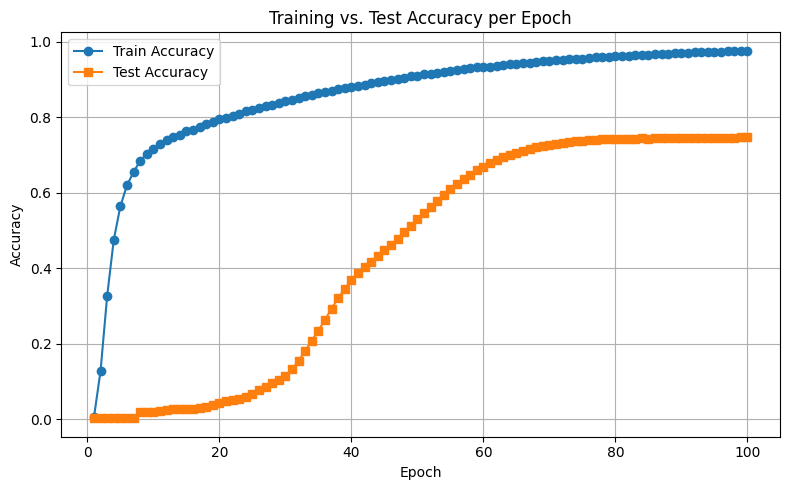

In [51]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs + 1), train_accuracies, marker='o', label="Train Accuracy")
plt.plot(range(1, num_epochs + 1), test_accuracies, marker='s', label="Test Accuracy")
plt.title("Training vs. Test Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [54]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.metrics import f1_score
# Put model in evaluation mode
model.eval()
with torch.no_grad():
    y_pred_logits = model(X_test_tensor)
    y_pred = torch.argmax(y_pred_logits, dim=1)

# Convert predictions and true labels to numpy for sklearn
y_pred_np = y_pred.numpy()
y_test_np = y_test_tensor.numpy()

# Accuracy
print(f"Accuracy: {accuracy_score(y_test_np, y_pred_np):.4f}")

# Classification report
from sklearn.metrics import classification_report

print(classification_report(y_test_np, y_pred_np, target_names=le.classes_, zero_division=0))
# Weighted F1 Score: accounts for class imbalance
f1_weighted = f1_score(y_test_np, y_pred_np, average='weighted', zero_division=0)
print(f"F1 Score (Weighted): {f1_weighted:.4f}")
# Confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test_np, y_pred_np))


Accuracy: 0.7463
                 precision    recall  f1-score   support

        allen-p       0.81      0.73      0.77       103
       arnold-j       0.66      0.70      0.68       216
        arora-h       0.62      0.25      0.36        20
       badeer-r       0.00      0.00      0.00         2
       bailey-s       0.00      0.00      0.00         4
         bass-e       0.76      0.62      0.68        73
     baughman-d       0.73      0.57      0.64        28
         beck-s       0.75      0.81      0.77       145
       benson-r       0.00      0.00      0.00         5
        blair-l       0.83      0.90      0.86       278
      brawner-s       0.73      0.36      0.48        22
          buy-r       0.79      0.81      0.80       117
     campbell-l       0.82      0.68      0.74        34
       carson-m       0.93      0.74      0.82        34
         cash-m       0.86      0.88      0.87       164
    causholli-m       0.95      0.94      0.95        67
       corman